In [ ]:
import numpy as np
import os
from tensorflow.keras.utils import to_categorical
import cv2

# 데이터 로드 함수
def load_images(image_dir, target_size=(64, 64)):
    images = []
    file_names = sorted(os.listdir(image_dir))  # 정렬하여 파일 순서를 맞춤
    for file_name in file_names:
        if file_name.endswith(".png"):
            img = cv2.imread(os.path.join(image_dir, file_name), cv2.IMREAD_GRAYSCALE)
            img = cv2.resize(img, target_size)  # 크기 조정
            images.append(img)
    return np.array(images)

input_path = "/Users/kimeunsur/2024winter/4주차/font_ai_model/ai_model/font_images/nanumgothic"
target_path = "/Users/kimeunsur/2024winter/4주차/font_ai_model/ai_model/font_images/font_dataset"
import os

# 파일 경로 확인
print("Input path exists:", os.path.exists(input_path))
print("Target path exists:", os.path.exists(target_path))

# 파일 목록 확인
print("Files in input path:", os.listdir(input_path))
print("Files in target path:", os.listdir(target_path))
# 입력(고딕체) 데이터와 타겟 데이터 로드
X_gothic = load_images(input_path)  # 고딕체 이미지
Y_target = load_images(target_path)  # 타겟 스타일 이미지

# 데이터 정규화 (픽셀 값을 [0, 1]로 스케일링)
X_gothic = X_gothic / 255.0
Y_target = Y_target / 255.0

# 차원 추가 (64x64 -> 64x64x1)
X_gothic = np.expand_dims(X_gothic, axis=-1)
Y_target = np.expand_dims(Y_target, axis=-1)

Input path exists: True
Target path exists: False
Files in input path: ['퐘.png', '곪.png', '뉦.png', '쳲.png', '캢.png', '뛤.png', '뾁.png', '뽆.png', '퓃.png', '쎔.png', '뢵.png', '즑.png', '궅.png', '툚.png', '늧.png', '쳳.png', '욆.png', '교.png', '쀣.png', '캖.png', '퀎.png', '듀.png', '쭸.png', '뉤.png', '쭷.png', '뻨.png', '뗓.png', '믖.png', '녕.png', '뷯.png', '빙.png', '쨏.png', '크.png', '먪.png', '뼈.png', '쀄.png', '챷.png', '륅.png', '음.png', '씖.png', '뎓.png', '봖.png', '톛.png', '튕.png', '쉣.png', '럛.png', '썂.png', '꺫.png', '꽺.png', '긬.png', '떝.png', '땜.png', '욯.png', '낯.png', '뼣.png', '럗.png', '쵣.png', '밭.png', '벬.png', '센.png', '뎾.png', '뀢.png', '싽.png', '삧.png', '뷛.png', '뢂.png', '튼.png', '팵.png', '콵.png', '뎮.png', '뚱.png', '쬅.png', '럴.png', '롂.png', '쩕.png', '콳.png', '쓥.png', '캺.png', '듷.png', '쭱.png', '욿.png', '젰.png', '즃.png', '퉔.png', '껱.png', '뭮.png', '햙.png', '뱄.png', '뵲.png', '븸.png', '쾽.png', '씃.png', '뽺.png', '촧.png', '쇽.png', '쀽.png', '룽.png', '뙒.png', '쐒.png', '꺆.png']


FileNotFoundError: [Errno 2] No such file or directory: '/Users/kimeunsur/2024winter/4주차/font_ai_model/ai_model/font_dataset/nanumpen'

In [2]:
# 스타일 정보 생성
num_samples = len(X_gothic)  # 데이터 샘플 수
num_styles = 5  # 예: 5개의 스타일
style_labels = np.random.randint(0, num_styles, size=(num_samples,))  # 랜덤 스타일 레이블
style_one_hot = to_categorical(style_labels, num_classes=num_styles)  # 원-핫 인코딩

# 모델 정의
input_img = layers.Input(shape=(64, 64, 1))  # 이미지 입력
style_input = layers.Input(shape=(num_styles,))  # 스타일 정보 입력

# Encoder
x = layers.Conv2D(32, (3, 3), activation='relu', padding='same')(input_img)
x = layers.MaxPooling2D((2, 2))(x) #이미지 크기 절반으로 64->32
x = layers.Conv2D(64, (3, 3), activation='relu', padding='same')(x)
encoded = layers.MaxPooling2D((2, 2))(x) #크기 32->16

# Style Embedding
style_embedding = layers.Dense(128, activation='relu')(style_input)

# Decoder
x = layers.Conv2DTranspose(64, (3, 3), activation='relu', padding='same')(encoded)
x = layers.UpSampling2D((2, 2))(x) #16->32
x = layers.Conv2DTranspose(32, (3, 3), activation='relu', padding='same')(x)
x = layers.UpSampling2D((2, 2))(x) #32->64
decoded = layers.Conv2DTranspose(1, (3, 3), activation='sigmoid', padding='same')(x)

NameError: name 'X_gothic' is not defined

In [35]:
# 모델 생성
model = Model([input_img, style_input], decoded)
model.compile(optimizer='adam', loss='mse', metrics=['accuracy'])

# 모델 학습
history = model.fit(
    [X_gothic, style_one_hot],  # 입력: 고딕체 이미지와 스타일 정보
    Y_target,                   # 출력: 타겟 폰트 이미지
    validation_split=0.2,       # 검증 데이터 비율
    epochs=50,                  # 학습 반복 횟수
    batch_size=32               # 배치 크기
)

Epoch 1/50


/Users/kimeunsur/yes/envs/newenv/lib/python3.11/site-packages/keras/src/models/functional.py:225: UserWarning: The structure of `inputs` doesn't match the expected structure: ['keras_tensor_72', 'keras_tensor_73']. Received: the structure of inputs=('*', '*')
  warnings.warn(


3/3 ━━━━━━━━━━━━━━━━━━━━ 3s 574ms/step - accuracy: 0.6052 - loss: 0.2243 - val_accuracy: 0.8671 - val_loss: 0.1483
Epoch 2/50
3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 302ms/step - accuracy: 0.8697 - loss: 0.1316 - val_accuracy: 0.8671 - val_loss: 0.0843
Epoch 3/50
3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 302ms/step - accuracy: 0.8690 - loss: 0.0831 - val_accuracy: 0.8671 - val_loss: 0.0847
Epoch 4/50
3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 309ms/step - accuracy: 0.8710 - loss: 0.0821 - val_accuracy: 0.8671 - val_loss: 0.0841
Epoch 5/50
3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 312ms/step - accuracy: 0.8689 - loss: 0.0830 - val_accuracy: 0.8671 - val_loss: 0.0839
Epoch 6/50
3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 303ms/step - accuracy: 0.8704 - loss: 0.0818 - val_accuracy: 0.8671 - val_loss: 0.0838
Epoch 7/50
3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 309ms/step - accuracy: 0.8694 - loss: 0.0824 - val_accuracy: 0.8671 - val_loss: 0.0838
Epoch 8/50
3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 301ms/step - accuracy: 0.8696 - loss: 0.0822 - val_accuracy: 0.8671 - val_loss: 0.0838
Epo

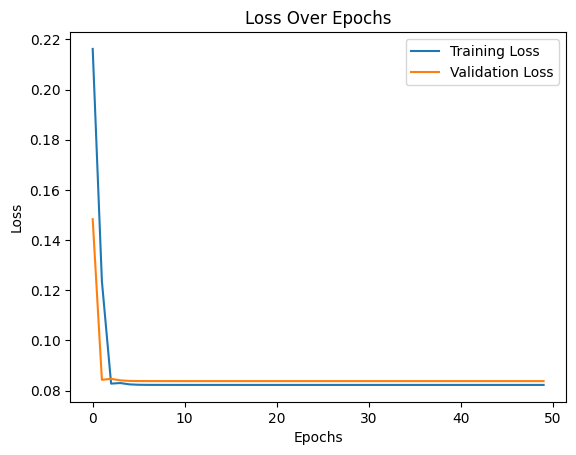

In [36]:
import matplotlib.pyplot as plt

plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.legend()
plt.title('Loss Over Epochs')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.show()

이제 전이학습일 시켜봅세다. transfer learning